In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

In [110]:
df = pd.read_csv("flight_data_kiwi_allsnaps_clean.csv")

/var/folders/3b/jd8k5j055rx3c991jlh5x05h0000gn/T/ipykernel_60934/2275512619.py:1: DtypeWarning: Columns (8,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("flight_data_kiwi_allsnaps_clean.csv")


In [111]:
df_filtered = df[df["Dep Company"] == df["Back Company"]].copy()
df_filtered["Company"] = df_filtered["Dep Company"]

In [112]:
def parse_price_string(s):

    if not isinstance(s, str):
        return np.nan
    
    # הסרה של כל התווים שאינם ספרה, נקודה או מינוס, והחלפת '₪' וכו'
    # אפשרות פשוטה היא לפצל על רווחים ולנסות להמיר כל חלק
    parts = s.replace('₪','').split()
    
    floats = []
    for p in parts:
        # מחק כל סימן שאינו ספרה/נקודה/מינוס
        p_clean = re.sub(r'[^0-9\.-]+', '', p)
        if p_clean:
            try:
                val = float(p_clean)
                floats.append(val)
            except ValueError:
                pass
    
    if len(floats) == 0:
        return np.nan
    else:
        # נניח שנחזיר את האחרון
        return floats[-1]

# כעת החלת הפונקציה על עמודת Price
df['Price'] = df['Price'].apply(parse_price_string)

# בדיקת כמות ה-NaN שנוצרו
print("Number of NaN after parse:", df['Price'].isna().sum())

Number of NaN after parse: 2


In [113]:
df_filtered["Dep Date"] = pd.to_datetime(df_filtered["Dep Date"])
df_filtered["Return Date"] = pd.to_datetime(df_filtered["Return Date"])
df_filtered["Snap Date"] = pd.to_datetime(df_filtered["Snap Date"])

# חישוב TTT (ימים בין SnapDate ל-DepDate)
df_filtered["TTT"] = (df_filtered["Dep Date"] - df_filtered["Snap Date"]).dt.days

# חישוב LOS (Length of Stay) - ימים בין DepDate ל-ReturnDate
df_filtered["LOS"] = (df_filtered["Return Date"] - df_filtered["Dep Date"]).dt.days


In [114]:
company_cols = df_company_features.columns.drop("Company")
X_companies = df_company_features[company_cols].values

# סקיילינג (אופציונלי)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_companies)


In [115]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df_company_features["cluster"] = labels

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


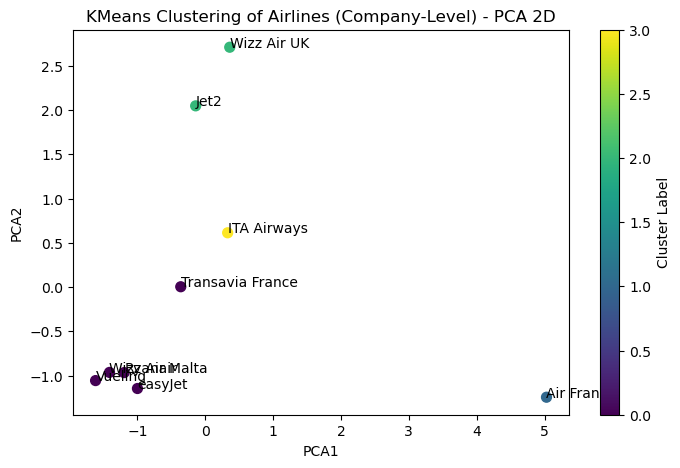

In [116]:
pca = PCA(n_components=2, random_state=42)
coords_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,5))
plt.scatter(coords_2d[:,0], coords_2d[:,1], c=labels, cmap='viridis', s=50)
for i, txt in enumerate(df_company_features["Company"]):
    plt.annotate(txt, (coords_2d[i,0], coords_2d[i,1]))
plt.title("KMeans Clustering of Airlines (Company-Level) - PCA 2D")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.colorbar(label="Cluster Label")
plt.show()

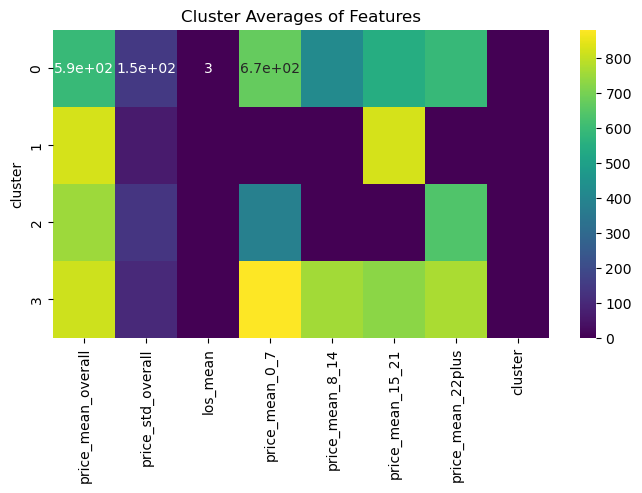

In [117]:
# נשמיט את עמודת Company וכל עמודה טקסטואלית, ונשאיר רק מספריות + cluster
df_for_heatmap = df_company_features.drop(columns=["Company"]).select_dtypes(include=[np.number])

# כעת נקבץ לפי cluster ונחשב ממוצע
df_for_heatmap = df_for_heatmap.groupby(df_company_features["cluster"]).mean()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.heatmap(df_for_heatmap, annot=True, cmap="viridis")
plt.title("Cluster Averages of Features")
plt.show()


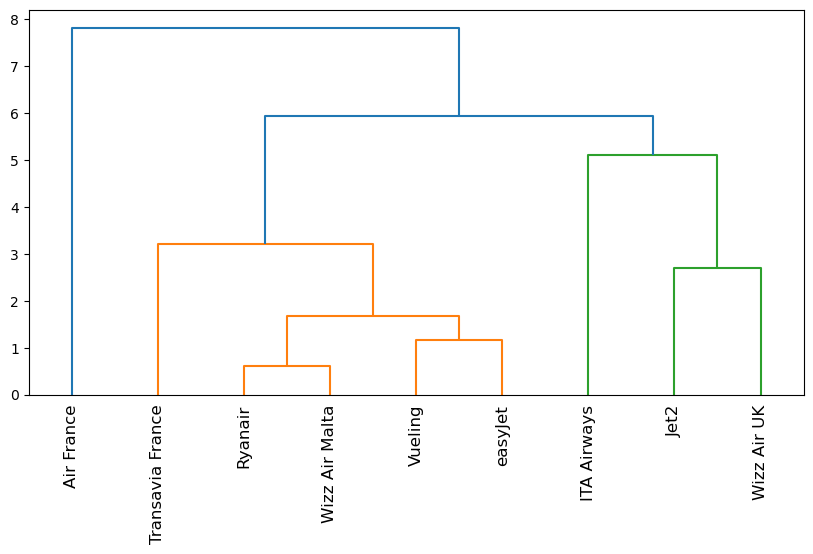

In [118]:
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(10,5))
dendrogram(Z, labels=df_company_features["Company"].values, leaf_rotation=90)
plt.show()

In [119]:
print("\n===== Clustering Results =====")
print(df_company_features[["Company","cluster"] + list(company_cols)])


===== Clustering Results =====
            Company  cluster  price_mean_overall  price_std_overall  los_mean  \
0        Air France        1          824.620000          65.080957  1.000000   
1       ITA Airways        3          813.214474         101.363920  2.692485   
2              Jet2        2          748.077849         139.500752  3.032819   
3           Ryanair        0          602.724445         138.029590  2.955203   
4  Transavia France        0          733.757114         131.208031  3.069982   
5           Vueling        0          540.508615         165.315864  3.016728   
6    Wizz Air Malta        0          608.974082         153.471190  3.031160   
7       Wizz Air UK        2          759.311856         132.930392  3.117904   
8           easyJet        0          488.180167         140.545422  2.936706   

   price_mean_0_7  price_mean_8_14  price_mean_15_21  price_mean_22plus  \
0        0.000000         0.000000        824.620000           0.000000   
1      